In [1]:
#importing necessary libraries
import glob
import nltk
import os
import time
import textwrap
import pandas as pd
import numpy as np
import json
import gensim
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#gensim libraries
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_documents
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import strip_tags, remove_stopwords, STOPWORDS
from sklearn.metrics import f1_score
from gensim.models import Word2Vec

#transformer libraries
from sentence_transformers import SentenceTransformer

#sk-learn libraries
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#confg libraries
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_excel("abstract_excel.xlsx") # reading excel file/csv file.

In [ ]:
## todo : make a copy df later at the end ......

In [3]:
df.head(4)

,Title,Abstract,Filename
0,One-stop shops for residential building energy renovation in the EU,"This report is the second part of a Europe-wide survey and assessment of one-stop shops (OSS) for energy renovation of buildings. Based on the case studies of 63 OSS in the EU, we find that the approach has a potential to cover 5-6% of the renovation volume of 35 million buildings in 2030 set out by the Renovation Wave Strategy1,2 at low social costs, integrating private investments with client-friendly methods. The current level of activity of the European OSS market is estimated to be around 100 000 projects per year.\nThe OSS can bridge the gap between a fragmented residential building sector, with a large heterogeneous set of households, and the construction supply side. They can help increase the actual renovation rate by supporting potential clients through the various steps of the decision-making process. Their success lies in part with their locally embedded focus, engagement with interested but not yet committed energy users/asset owners and ability to form strong relationships with clients. They can support the renovation journey from start to finish and can facilitate access to financing, occasionally offering better rates. While our analysis identifies several structural, legislative, financial, and information measures with a positive impact on OSS-enabled renovation projects, it is possible to enhance their contribution by reviewing specific policies that support or hinder their success. Although not typical of OSS in general, but with proper incentives, they can improve the average renovation depth in terms of energy performance level by adopting a holistic approach and, at the same time, they can reach out to vulnerable populations, such as tenants of social houses, thus contributing to the alleviation of energy poverty. Finally, OSS can contribute to the enhancement of communities and neighbourhoods. They help current tenants to improve their living conditions and thus stay in the area.",One-stop shops for residential building.pdf
1,HOW BUILDING INSULATION CAN REDUCE FOSSIL FUEL IMPORTS AND BOOST EU ENERGY SECURITY,"This paper investigates how improving the energy performance of the building envelope in selected EU Member States would lower fossil fuel consumption, increase energy security and enable the growth of renewable heat. The study shows how improving insulation can reduce energy demand and drastically cut Russian oil and gas imports for heating in buildings. Investing in building renovation can reduce the use of fossil fuels for heating in buildings, reaching 44% in gas savings, save 45% of final energy demand and substantially contribute to securing the EU’s energy needs.",HOW BUILDING INSULATION CAN REDUCE.pdf
2,Impact assessment of the MEPS under discussion in the context of the EPBD,"Minimum Energy Performance Standards (MEPS) are under discussion in the frame of the revision of the Energy Performance of Buildings Directive (EPBD) as a tool to trigger renovation of buildings in the European Union and reduce GHG emissions. To inform this discussion, Climact and BPIE modelled the impacts of MEPS schemes on the European building stock. This allows comparing the ambition of MEPS as originally proposed by the European Commission with two other scenarios: the REPowerEU plan and a scenario aligned with the EU climate and energy consumption reduction targets set by Fitfor552. The modelling was done in June 2022 and mainly accounts for the proposals from the EU Commission, REPowerEU and the EP rapporteur for the EPBD revision, Ciáran Cuffe.",Impact assessment of the MEPS.pdf
3,Recommendations for industrialised renovation,"Action and innovation are needed to achieve the EU climate goal of full, societywide\ndecarbonisation by 2050. The EU is committed to a 55% reduction of\ngreenhouse-gas emissions by 2030.1 The 2022 REPowerEU plan puts increased\nemphasis on decarbonisation, notably through reducing energy dema

In [4]:
## creating a list for storing the abstract and filename column 
abstract_list = df['Abstract']
filename_list = df["Filename"]

In [5]:
filename_list[82]

'Values-and-implications-of-building-envelope-retrofitting_2022_Energy.pdf'

#### Preprocessing of the text  

1. remove punctuation and stopwords.
2. implement lemmatization
3. unnecessary white space chr and space. +++

In [6]:
#stop word removal 
import spacy
nlp=spacy.load('en_core_web_sm')
import string
from spacy.lang.en.stop_words import STOP_WORDS

In [7]:
punctuations = string.punctuation
stop_words = list(STOP_WORDS)

custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', "energy"
]

#add domain stop words

for w in custom_stop_words:
    if w not in stop_words:
        stop_words.append(w)

In [8]:
def tokenize_corpus(abstract_text):
    mytokens = nlp(abstract_text)
    mytokens = [ word.lemma_.strip() if word.lemma_ != "-PRON-" else word for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [9]:
df["processed_text"] = df["Abstract"].apply(tokenize_corpus)

In [10]:
df.Filename[35]

'Proof.pdf'

#### Applying Word-Embedding

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    print(vectorizer.get_feature_names_out())
    return X

In [12]:
pro_text = df['processed_text'].values
max_features = 2**8
X = vectorize(pro_text, max_features)

['2050' 'account' 'achieve' 'action' 'address' 'aim' 'air' 'allow'
 'alternative' 'analyse' 'analysis' 'annual' 'application' 'apply'
 'approach' 'area' 'article' 'assess' 'assessment' 'average' 'barrier'
 'base' 'benefit' 'build' 'building' 'carbon' 'case' 'challenge' 'change'
 'circular' 'city' 'climate' 'co2' 'combine' 'comfort' 'compare'
 'component' 'comprehensive' 'concept' 'condition' 'consider'
 'construction' 'consumption' 'context' 'contribute' 'control' 'cool'
 'cost' 'country' 'current' 'cycle' 'datum' 'decision' 'define' 'demand'
 'design' 'develop' 'development' 'different' 'directive' 'district'
 'dynamic' 'economic' 'economy' 'effect' 'effective' 'efficiency'
 'efficient' 'electricity' 'element' 'embody' 'emission' 'enable' 'end'
 'energy' 'envelope' 'environment' 'environmental' 'eu' 'europe'
 'european' 'evaluate' 'evaluation' 'exist' 'factor' 'far' 'find' 'focus'
 'framework' 'future' 'gap' 'gas' 'global' 'goal' 'good' 'green'
 'greenhouse' 'grid' 'heat' 'heating' 'h

#### Application of clustering algorithm

In [13]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k values
distortions = []
K = range(2, 15)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X)
    k_means.fit(X)
    distortions.append(sum(np.min(cdist(X.toarray(), k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

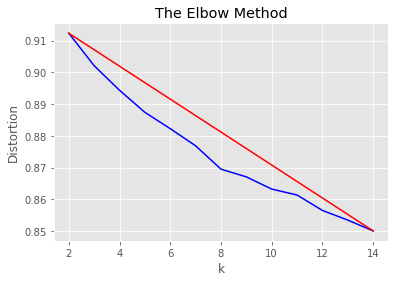

In [14]:
plt.style.use('ggplot')

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

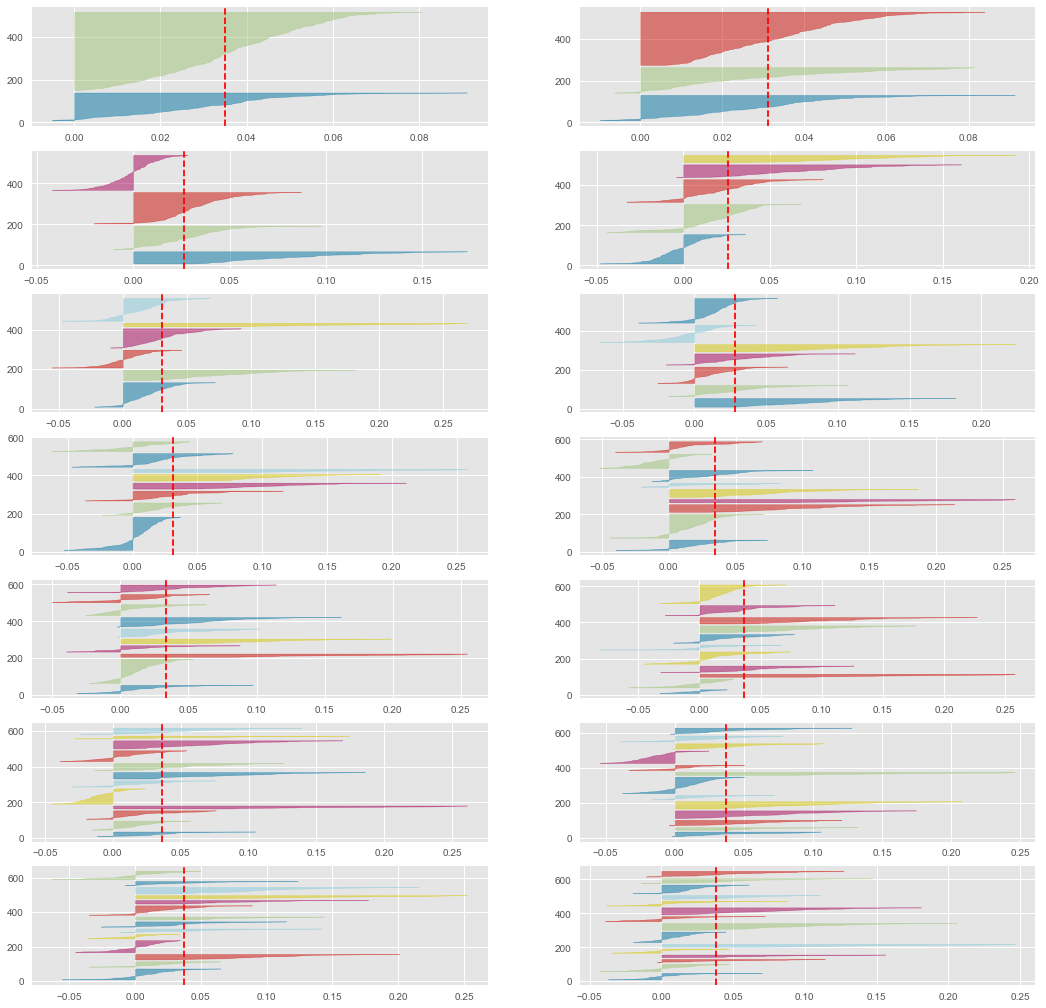

In [84]:
# from sklearn import datasets
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt
# from yellowbrick.cluster import SilhouetteVisualizer

# fig, ax = plt.subplots(7, 2, figsize=(18,18))
# for i in [2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15]:

#     '''
#     Create KMeans instances for different number of clusters
#     '''
#     km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
#     q, mod = divmod(i, 2)
#     '''
#     Create SilhouetteVisualizer instance with KMeans instance
#     Fit the visualizer
#     '''
#     visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
#     visualizer.fit(X) 

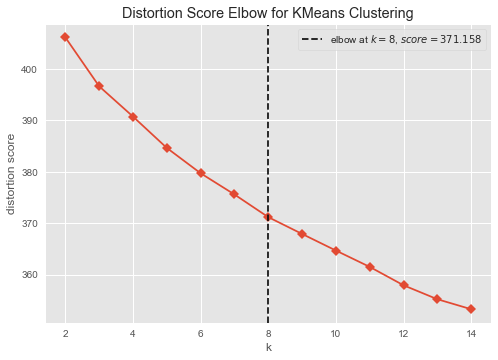

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [93]:
# from sklearn import datasets
# from sklearn.cluster import KMeans
# from yellowbrick.cluster import KElbowVisualizer



# # Instantiate the clustering model and visualizer
# km = KMeans(random_state=42)
# visualizer = KElbowVisualizer(km, k=(2,15), timings= False)
 
# visualizer.fit(X)        # Fit the data to the visualizer
# visualizer.show()        # Finalize and render the figure

After performing "elbow method" twice and "silhouette-score" , we come to the conclusion that k=9 is the optimal value for k-means algo.

In [15]:
k = 9 # as decided 
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)
df['cluster_no'] = y_pred

In [16]:
tsne = TSNE(verbose=1, perplexity=50)  # Changed perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.028s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.348608
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.409691
[t-SNE] KL divergence after 1000 iterations: 1.303968


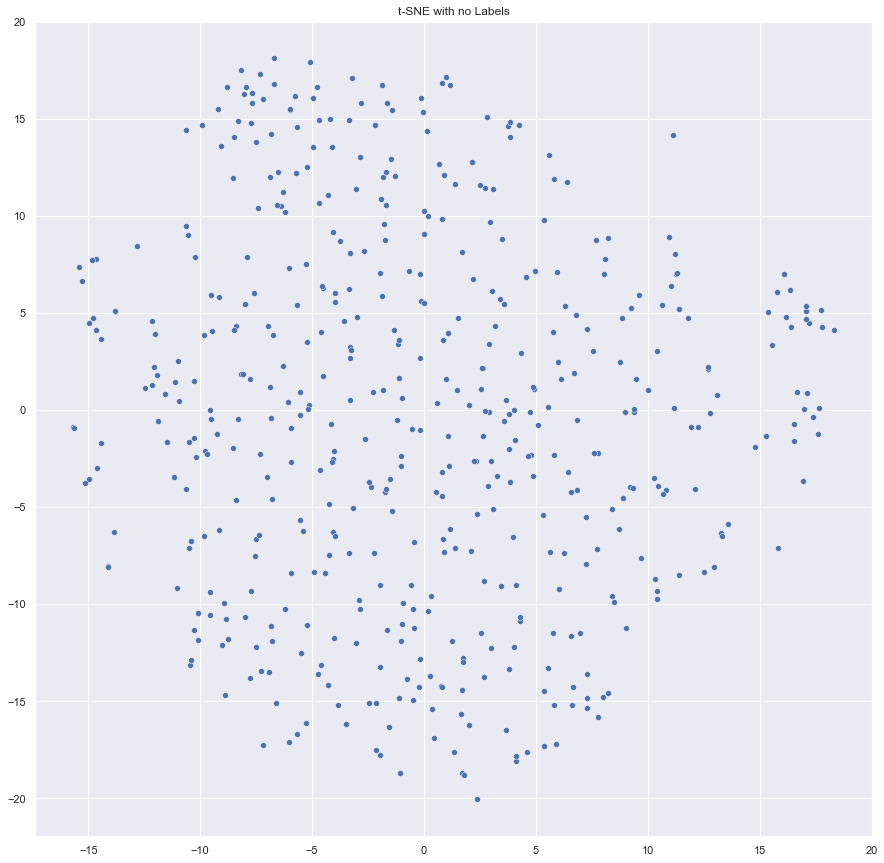

In [17]:
# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_no_labels.png")
plt.show()

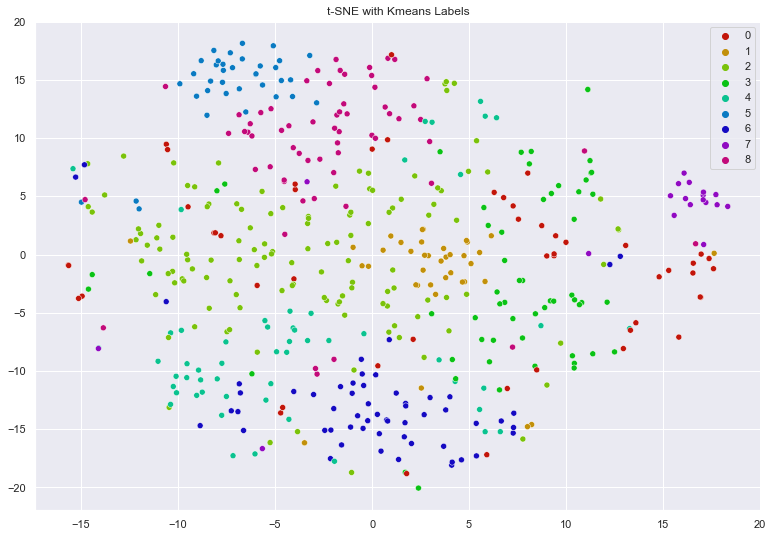

In [18]:
%matplotlib inline

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(9, l=0.4, s=0.9)

# plot
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [52]:
#### perform elbow method -  ✔
#### decide on number of cluster based on elbow method -  ✔
#### try to visulaize in the graph - ✔

#### TODO:
## ----------
#### vectorize the data ✔
#### perform topic modeling ✔
#### append the keywords to df ✔

In [87]:
# df['cluster_no'].value_counts()

### Topic Modeling for each cluster

In [19]:
# first we will create 9 vectorizers for each cluster

####------#####
# Using TF-IDF (Term Frequency-Inverse Document Frequency) instead of raw counts (as in Count-Vectorizer) for LDA (Latent Dirichlet Allocation) 
# can lead to less effective topic modeling for several reasons:
# Loss of Raw Count Information: TF-IDF considers the frequency of terms in individual documents as well as their importance across the 
# entire corpus. While this can be useful for tasks like document classification or information retrieval, it may not preserve the 
# raw count information that is crucial for LDA.


vectorizers = []
    
for ii in range(0, 9):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [20]:
vectorizers[0]

CountVectorizer(max_df=0.9, min_df=5, stop_words='english',
                token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}')

In [21]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df["cluster_no"] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [22]:
len(vectorized_data)

9

In [23]:
NUM_TOPICS_PER_CLUSTER = 9


lda_models = []

for ii in range(0, 9):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=9,
                          random_state=42, verbose=False)

In [24]:
# for each cluster we will create a separate lda model and basically apply the fit transform to each lda model (cluster).
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8


In [25]:
#extracts the keywords from each cluster

# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [26]:
#append list of keywords for a single cluster.

all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8


In [27]:
# Creating a new column 'generated keywords' in the DataFrame
df['generated keywords'] = None

# Loop through the DataFrame rows and set the 'generated keywords' column based on the labels
for index, row in df.iterrows():
    label = row['cluster_no']
    keywords_for_label = all_keywords[label]  # Get the corresponding keywords for the label
    df.at[index, 'generated keywords'] = ', '.join(keywords_for_label)

In [28]:
all_keywords[0]

['occupant',
 'indoor',
 'factor',
 'ventilation',
 'comfort',
 'study',
 'green',
 'performance',
 'smart',
 'scenario',
 'air',
 'renewable',
 'urban',
 'country',
 'european',
 'model',
 'use',
 'building',
 'provide']

#### Query Matching 

In [29]:

# Query string
query = "What is Nzeb ? "

# Function to semantically match query to text in DataFrame column
def semantic_match(query, text_column):
    # Load pre-trained BERT model
    model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
    
    # Encode query and text data
    query_embedding = model.encode([query])
    text_embeddings = model.encode(text_column)
    
    # Compute cosine similarity between query embedding and text embeddings
    similarities = cosine_similarity(query_embedding, text_embeddings)
    
    # Get index of text with highest similarity
    match_index = similarities.argmax()
    
    # Return the matched text and its index
    return text_column[match_index], match_index

# Perform semantic matching
matched_text, match_index = semantic_match(query, df['Abstract'])

print("Query:", query)
print("Matched Text:", matched_text)
print("Matched Index:", match_index)

Query: What is Nzeb ? 
Matched Text: Buildings are a major primary energy consumer in the world energy sector, with a value of about 40% of total energy consumption. The absence of traditional sources of energy currently promotes the development of Net Zero Energy Buildings (NZEBs). The general definition of net zero energy construction is very critical to grasp. The aim of the paper is to overview the literature on the existing NZEB to make them self-sustaining and net zero in order to improve energy efficiency of the buildings. If enough renewable energy could be used, NZEB could potentially be achievable with power production. Furthermore, different building-service systems utilizing renewable energy sources have been extensively investigated for possible uses in NZEB. The paper gives the detail of its climatic condition in various part of the world along with their consequences and its impacts. The NZEB concept will significantly define the demand and supply strategies for renewabl

In [30]:
# fetching the matched cluster number 
matched_cluster = df['cluster_no'][match_index]

In [31]:
matched_cluster

2

In [32]:
# get all the filenames of the matched cluster from the matched cluster_no
matched_filenames = list(df.loc[df['cluster_no'] == matched_cluster, 'Filename'])

In [33]:
matched_filenames

['Impact assessment of the MEPS.pdf',
 'Recommendations for industrialised renovation.pdf',
 'EPBD_Crunch-time-for-future-proof-buildings-legislation_final.pdf',
 'aus-energiekrise-durch-effizienz-suffizienz.pdf',
 'financingenergyefficiency2may2017.pdf',
 'Background_report_window_frames_PVC_alu_wood_draft_confidential.pdf',
 'Potential Impact of High Performance Glazing on Energy and CO2 Savings in Europe.pdf',
 'The-role-of-the-occupant-behavior-in-affecting-the-feasibility_2020_Energy.pdf',
 'Overview-and-future-challenges-of-nearly-zero-energy-build_2022_Energy.pdf',
 'Potential-analysis-of-grey-energy-limits-for-residential_2016_germany.pdf',
 'Values-and-implications-of-building-envelope-retrofitting_2022_Energy.pdf',
 'Energy-consumption-reduction-proposals-for-thermal-system_in_residential_building_2018.pdf',
 'Building-energy-consumption-status-worldwide-and-the-state-of_art_2016.pdf',
 'Multi-criteria-assessment-approach-for-a-residential-building_norway_2020.pdf',
 'Influen

In [75]:
 matched_files= ["File_data/" + s for s in matched_filenames]

In [76]:
matched_files

['File_data/Impact assessment of the MEPS.pdf',
 'File_data/Recommendations for industrialised renovation.pdf',
 'File_data/EPBD_Crunch-time-for-future-proof-buildings-legislation_final.pdf',
 'File_data/aus-energiekrise-durch-effizienz-suffizienz.pdf',
 'File_data/financingenergyefficiency2may2017.pdf',
 'File_data/Background_report_window_frames_PVC_alu_wood_draft_confidential.pdf',
 'File_data/Potential Impact of High Performance Glazing on Energy and CO2 Savings in Europe.pdf',
 'File_data/The-role-of-the-occupant-behavior-in-affecting-the-feasibility_2020_Energy.pdf',
 'File_data/Overview-and-future-challenges-of-nearly-zero-energy-build_2022_Energy.pdf',
 'File_data/Potential-analysis-of-grey-energy-limits-for-residential_2016_germany.pdf',
 'File_data/Values-and-implications-of-building-envelope-retrofitting_2022_Energy.pdf',
 'File_data/Energy-consumption-reduction-proposals-for-thermal-system_in_residential_building_2018.pdf',
 'File_data/Building-energy-consumption-status-wor

### Start : RAG approach
### Goal: To make use of matched data only for RAG

In [ ]:
# copy of the RAG_simple.ipynb , just that we have to figure out the way to use this filtered documents with the rag model.

In [36]:
# libraries required for RAG :

import langchain 
from langchain_community.llms import LlamaCpp


# loaders
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DirectoryLoader

# splits
from langchain.text_splitter import RecursiveCharacterTextSplitter

# prompts
from langchain import PromptTemplate, LLMChain

# vector stores
from langchain.vectorstores import FAISS

# models
from langchain.llms import HuggingFacePipeline
from InstructorEmbedding import INSTRUCTOR
from langchain.embeddings import HuggingFaceInstructEmbeddings

# retrievers
from langchain.chains import RetrievalQA

import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

print('LangChain:', langchain.__version__)

LangChain: 0.1.0


In [37]:
class Config:
    # LLMs
    model_name = 'llama2-7b'# llama2-7b, llama2-13b (gguf models that can run on cpu)
    temperature = 0,
    top_p = 0.95,
    repetition_penalty = 1.15

    # splitting
    split_chunk_size = 800
    split_overlap = 0

    # embeddings
    embeddings_model_repo = 'sentence-transformers/all-MiniLM-L6-v2'

    # similar passages
    k = 3

    # paths
    PDFs_path = 'File_data'
    Embeddings_path = 'lit_embedding'

#### Document loader

In [85]:
#Document Load

# loader = DirectoryLoader(
#     Config.PDFs_path,
#     glob="./*.pdf",
#     loader_cls=PyPDFLoader,
#     show_progress=True,
#     use_multithreading=True
# )

# documents = loader.load()

#### Document Splitter

In [86]:
#splitting the document into chunks 

# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size = Config.split_chunk_size,
#     chunk_overlap = Config.split_overlap
# )

# texts = text_splitter.split_documents(documents)

# # print(f'We have created {len(texts)} chunks from {len(documents)} pages')

#### Creating Embeddings 

In [248]:
# Important : Don't have to run it again as once the embeddings are created fot the text , it just need to be save and load later on.

# # %%time

# ### download embeddings model
# embeddings = HuggingFaceInstructEmbeddings(
#     model_name = Config.embeddings_model_repo,
#     # model_kwargs = {"device": "cuda"}
# )

# ### create embeddings and DB
# vectordb = FAISS.from_documents(
#     documents = texts, 
#     embedding = embeddings
# )

# ### persist vector database
# vectordb.save_local("lit_embedding")

load INSTRUCTOR_Transformer
max_seq_length  512


#### LLM RUN AND CONFIG 

In [38]:
n_gpu_layers = 1  # Metal set to 1 (only for mac m1 )
n_batch = 512  #number of tokens to process in parallel. 


llm = LlamaCpp(
    model_path="/Users/bivasbisht/Thesis/llama-2-7b-chat.Q5_K_M.gguf",
    n_gpu_layers=n_gpu_layers,
    n_batch=n_batch,
    n_ctx=2048,
    f16_kv=True,  # MUST set to True
    verbose=True,
)

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from /Users/bivasbisht/Thesis/llama-2-7b-chat.Q5_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 llama.attention.head_

In [39]:
%time
llm.invoke("what is Nzeb")

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 14.1 µs



llama_print_timings:        load time =    8695.99 ms
llama_print_timings:      sample time =      65.07 ms /   256 runs   (    0.25 ms per token,  3933.98 tokens per second)
llama_print_timings: prompt eval time =    8695.92 ms /     6 tokens ( 1449.32 ms per token,     0.69 tokens per second)
llama_print_timings:        eval time =   80156.78 ms /   255 runs   (  314.34 ms per token,     3.18 tokens per second)
llama_print_timings:       total time =   89998.77 ms /   261 tokens


'e?\nAnother term for the Igbo people of Nigeria and other parts of West Africa. The term "Nzebe" was popularized by the Nigerian writer and poet, Chinua Achebe, in his book "Things Fall Apart." In the book, Achebe uses the term to refer to the pre-colonial Igbo culture and way of life.\nThe use of the term "Nzebe" reflects the complexity and diversity of Nigerian cultures, as well as the fluidity of language and identity in West Africa. The term has since been adopted by some scholars and writers to refer to the Igbo people more broadly, encompassing not only their cultural practices but also their historical experiences and political aspirations.\nThe use of the term "Nzebe" is not without controversy, however. Some critics argue that it reinforces a narrow and essentialist view of Nigerian cultures, obscuring the diversity and complexity of identities within the country. Others argue that it reflects a legitimate effort to reclaim and redefine cultural identity in the face of coloni

#### Loading the saved embeddings 

In [40]:

%time

### download embeddings model
embeddings = HuggingFaceInstructEmbeddings(
    model_name = Config.embeddings_model_repo
    # model_kwargs = {"device": "cuda"}
)

### load vector DB embeddings
vectordb = FAISS.load_local(
    Config.Embeddings_path,
    embeddings
)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 9.06 µs
load INSTRUCTOR_Transformer
max_seq_length  512


In [105]:
#checking if the similar text being returned from the retriever based on the text provide to retriever
docs = vectordb.similarity_search_with_score('what is Nzeb ?',filter={"source":matched_files})

In [106]:
# filtered = db.similarity_search_with_relevance_scores(k=5, query=query, filter={'key1': {'$in': [value1, value2]}})
docs

[(Document(page_content='4. Discussion\nIn this study, ten Eastern European Countries (Bulgaria, Croatia,\nCzechia, Estonia, Hungary, Latvia, Lithuania, Poland, Romania, andSlovakia) were examined in-depth regarding the legislation\nrequirements of nZEB. The study aims to increase the market\nuptake of nZEB and strengthen its implementation and standards.\nThe key study ﬁndings and recommendations are presented based\non the result analysis. The next step in the market development of\nnZEB in EE countries is to consolidate the existing standards before\ndeveloping the nZEB renovation schemes [41]. The recommenda-\ntions are discussed in future perspectives for policymakers, fund-\ning agencies, and building stakeholders. The following sections\nelaborate on the study’s strengths, limitations, and future works.', metadata={'source': 'File_data/Overview-and-future-challenges-of-nearly-zero-energy-build_2022_Energy.pdf', 'page': 11}),
  0.7069453),
 (Document(page_content='stressed that t

In [44]:
docs

[(Document(page_content='gained each year as a result of deep retrofitting of buildings, and the construction of Passivhaus1 \n \n1 Passivhaus residences are very low energy buildings which require little energy for space heating and cooling. In particular, Passivhaus buildings efficiently exploit sun, \ninternal heat sources, heat recovery, strategic shading, passive cooling techniques, hence rendering conventional heating and cooling systems unnecessary.', metadata={'source': 'File_data/REFEREE Real Value of Energy Efficiency.pdf', 'page': 7}),
  0.79761577),
 (Document(page_content='Journal of Building Engineering 76 (2023) 107234\n3buildings [11]. \nMember States are allowed to adapt the regulations to their specific needs with a progressive tightening of minimum requirements \ntowards a nZEB model [12]. Several Member States have already provided a quantitative definition and chose the Passivhaus standard \nas a reference to ensure that the energy demands of buildings in their ter

In [286]:
docs

[(Document(page_content='gained each year as a result of deep retrofitting of buildings, and the construction of Passivhaus1 \n \n1 Passivhaus residences are very low energy buildings which require little energy for space heating and cooling. In particular, Passivhaus buildings efficiently exploit sun, \ninternal heat sources, heat recovery, strategic shading, passive cooling techniques, hence rendering conventional heating and cooling systems unnecessary.', metadata={'source': 'File_data/REFEREE Real Value of Energy Efficiency.pdf', 'page': 7}),
  0.79761577),
 (Document(page_content='Journal of Building Engineering 76 (2023) 107234\n3buildings [11]. \nMember States are allowed to adapt the regulations to their specific needs with a progressive tightening of minimum requirements \ntowards a nZEB model [12]. Several Member States have already provided a quantitative definition and chose the Passivhaus standard \nas a reference to ensure that the energy demands of buildings in their ter

In [123]:
# similarity_score_list = []

# for i in range(len(docs)):
#     score = docs[i][1]
#     similarity_score_list.append(score)


In [107]:
#custom prompt for the llm 

prompt_template = """
Don't try to make up an answer, if you don't know just say that you don't know.
Answer in the same language the question was asked.
Use only the following pieces of context to answer the question at the end.

{context}

Question: {question}
Answer:"""


PROMPT = PromptTemplate(
    template = prompt_template,
    input_variables = ["context", "question"]
)

In [108]:
retriever = vectordb.as_retriever(search_kwargs = {"k": Config.k, "search_type" : "similarity",'filter': {"source": matched_files}})

In [109]:
#retrieval chain / pipeline / QnA chain

from langchain_core.runnables import RunnablePassthrough, RunnablePick
from langchain_core.output_parsers import StrOutputParser

# question = "what is Nzeb?"

qa_chain = RetrievalQA.from_chain_type(
llm,
chain_type = "stuff",
retriever=retriever,
chain_type_kwargs={"prompt": PROMPT},
return_source_documents = True,
verbose = False
)



### other format for the qna chain
# Chain
# chain = (
#     RunnablePassthrough.assign(context=RunnablePick("context"))
#     | PROMPT
#     | llm
#     | StrOutputParser()
# )

# chain = (
#     {"context": retriever , "question": RunnablePassthrough()}
#     | PROMPT
#     | llm
#     | StrOutputParser()
# )

# Run
# chain.invoke(question)

In [110]:
# function for generating llm response
def llm_ans(query):
    start = time.time()
    
    llm_response = qa_chain.invoke(query)
    ans = process_llm_response(llm_response)
    
    end = time.time()

    time_elapsed = int(round(end - start, 0))
    time_elapsed_str = f'\n\nTime elapsed: {time_elapsed} s'
    return ans + time_elapsed_str


In [111]:
#processing the layout of the generated text from the llm , formatting the llm response


def wrap_text_preserve_newlines(text, width=700):
    # Split the input text into lines based on newline characters
    lines = text.split('\n')

    # Wrap each line individually
    wrapped_lines = [textwrap.fill(line, width=width) for line in lines]

    # Join the wrapped lines back together using newline characters
    wrapped_text = '\n'.join(wrapped_lines)

    return wrapped_text


def process_llm_response(llm_response):
    ans = wrap_text_preserve_newlines(llm_response['result'])

    sources_used = ' \n'.join(
        [
            source.metadata['source'].split('/')[-1][:-4] + ' - page: ' + str(source.metadata['page'])
            for source in llm_response['source_documents']
        ]
    )

    ans = ans + '\n\nSources: \n' + sources_used
    return ans 


In [113]:
query = "What is nzeb?"
print(llm_ans(query))

Llama.generate: prefix-match hit


 Based on the information provided in the text, NZEB stands for "Nearly Zero Energy Building".

Sources: 
Overview-and-future-challenges-of-nearly-zero-energy-build_2022_Energy - page: 11 
Criteria-and-structure-of-a-harmonised-data-collection-for-NZ_2017_Energy-Pr - page: 9 
Overview-and-future-challenges-of-nearly-zero-energy-build_2022_Energy - page: 1

Time elapsed: 247 s



llama_print_timings:        load time =    8695.99 ms
llama_print_timings:      sample time =       4.87 ms /    23 runs   (    0.21 ms per token,  4727.65 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =  246350.22 ms /    23 runs   (10710.88 ms per token,     0.09 tokens per second)
llama_print_timings:       total time =  246517.14 ms /    24 tokens


In [114]:
matched_files

['File_data/Impact assessment of the MEPS.pdf',
 'File_data/Recommendations for industrialised renovation.pdf',
 'File_data/EPBD_Crunch-time-for-future-proof-buildings-legislation_final.pdf',
 'File_data/aus-energiekrise-durch-effizienz-suffizienz.pdf',
 'File_data/financingenergyefficiency2may2017.pdf',
 'File_data/Background_report_window_frames_PVC_alu_wood_draft_confidential.pdf',
 'File_data/Potential Impact of High Performance Glazing on Energy and CO2 Savings in Europe.pdf',
 'File_data/The-role-of-the-occupant-behavior-in-affecting-the-feasibility_2020_Energy.pdf',
 'File_data/Overview-and-future-challenges-of-nearly-zero-energy-build_2022_Energy.pdf',
 'File_data/Potential-analysis-of-grey-energy-limits-for-residential_2016_germany.pdf',
 'File_data/Values-and-implications-of-building-envelope-retrofitting_2022_Energy.pdf',
 'File_data/Energy-consumption-reduction-proposals-for-thermal-system_in_residential_building_2018.pdf',
 'File_data/Building-energy-consumption-status-wor